## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

The goal of this project is to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from scipy.stats import kruskal
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Data Overview

In [2]:
loan_df = pd.read_csv('Loan_Modelling.csv')

In [3]:
loan_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
# checking shape of the data
print(f"There are {loan_df.shape[0]} non-null rows and {loan_df.shape[1]} columns.")

There are 5000 non-null rows and 14 columns.


In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


**There are both quantitative and categorical variables in `loan_df`. All the columns have numeric data types.**

In [6]:
loan_df.duplicated().sum()

0

**No duplicates in `loan_df`.**

## Exploratory Data Analysis.

**1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?**

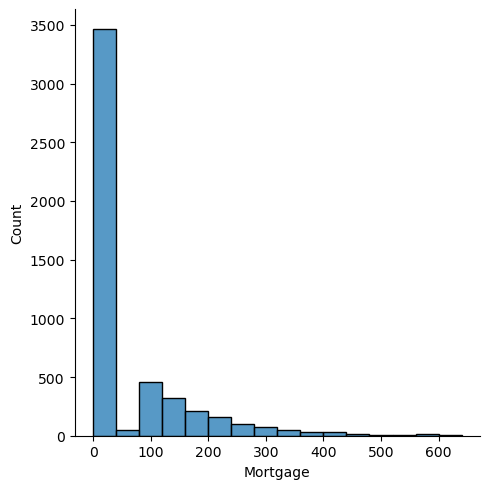

In [7]:
# distribution of mortgage attribute
sns.displot(loan_df, x="Mortgage", binwidth=40);

- The mortgage attribute shows a right-skewed distribution, with some noticeable outliers, where most customers have low mortgage values, but a small number of customers have much higher values .

**2. How many customers have credit cards?**

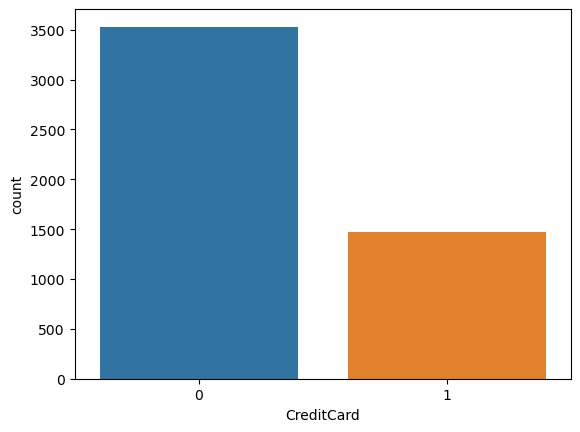

In [8]:
# How many customers have credit cards?
sns.countplot(loan_df, x='CreditCard');

In [9]:
loan_df['CreditCard'].value_counts()

CreditCard
0    3530
1    1470
Name: count, dtype: int64

-  Of the 5000 customers, 1470 have credit cards, while the remaining 3530 do not.

**3. What are the attributes that have a strong correlation with the target attribute (personal loan)?**

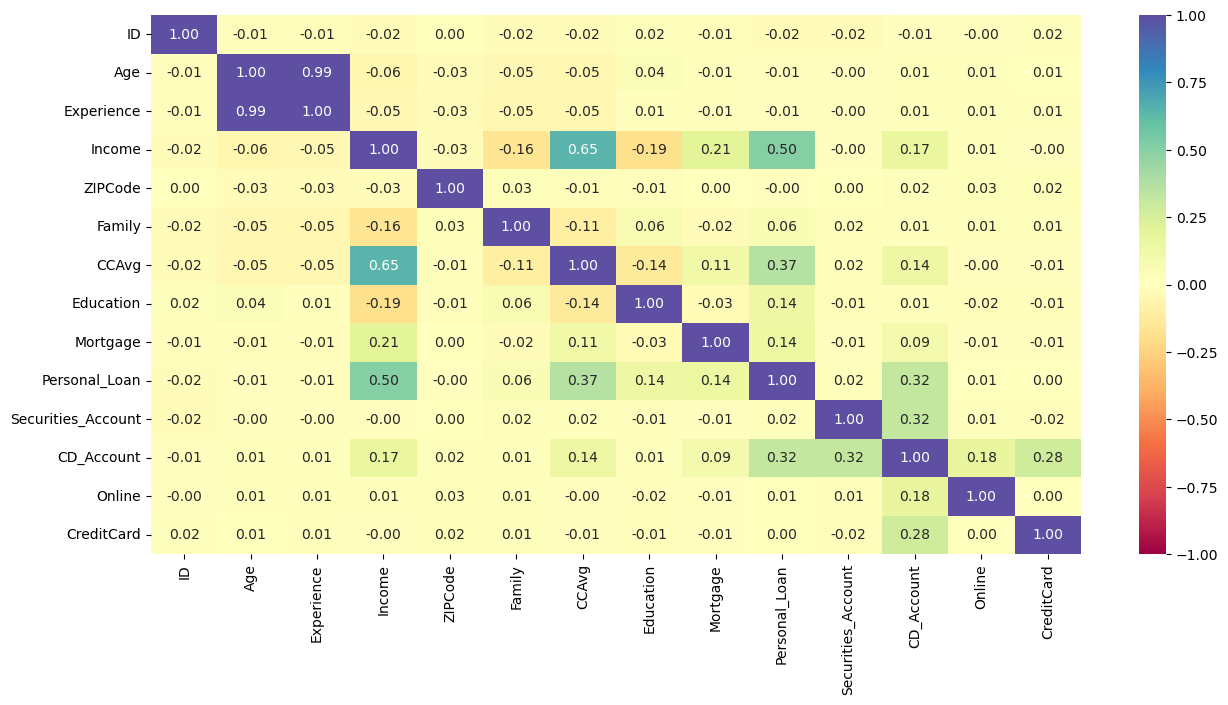

In [10]:
#correlation between independent variables and target variable

cols_list = loan_df.columns.tolist()

plt.figure(figsize=(15, 7))
sns.heatmap(
    loan_df[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

- Attributes such as `Income`, `Mortgage`, `CCAvg` (Credit Card Average spending), `Education`, and `CD_Account` have a moderate to strong correlation with the target variable, `Personal_Loan` .

**4. How does a customer's interest in purchasing a loan vary with their age?**

In [11]:
# loan column: value counts

loan_df['Personal_Loan'].value_counts(normalize=True)

Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64

In [12]:
# frequency of customers, by Age, who are or aren't interested in loans

pd.crosstab(loan_df['Age'], loan_df['Personal_Loan'])

Personal_Loan,0,1
Age,,
23,12,0
24,28,0
25,53,0
26,65,13
27,79,12
28,94,9
29,108,15
30,119,17
31,118,7


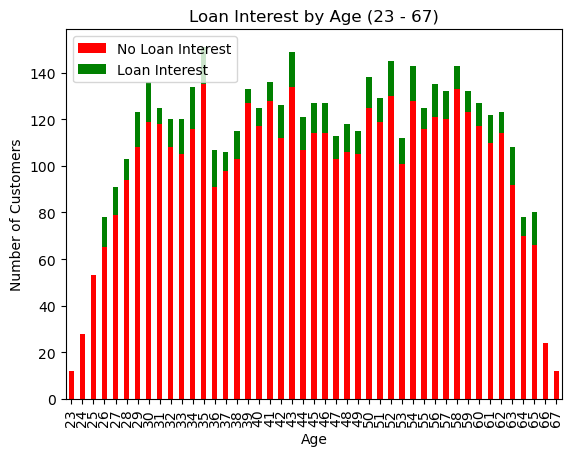

In [13]:
# frequency of customers, by Age, who are or aren't interested in loans

pd.crosstab(loan_df['Age'], loan_df['Personal_Loan']).plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Loan Interest by Age (23 - 67)')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.legend(['No Loan Interest', 'Loan Interest']);

In [14]:
# chi-square test

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(loan_df['Age'], loan_df['Personal_Loan'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}')
print(f'P-Value: {p}')

Chi-Square Statistic: 55.19095685491293
P-Value: 0.12012752530961479


In [15]:
# Average Loan Interest by Age

age_loan = loan_df.groupby(['Age'])['Personal_Loan'].mean()
age_loan

Age
23    0.000000
24    0.000000
25    0.000000
26    0.166667
27    0.131868
28    0.087379
29    0.121951
30    0.125000
31    0.056000
32    0.100000
33    0.125000
34    0.134328
35    0.105960
36    0.149533
37    0.075472
38    0.104348
39    0.045113
40    0.064000
41    0.058824
42    0.111111
43    0.100671
44    0.115702
45    0.102362
46    0.102362
47    0.088496
48    0.101695
49    0.086957
50    0.094203
51    0.077519
52    0.103448
53    0.098214
54    0.104895
55    0.072000
56    0.103704
57    0.090909
58    0.069930
59    0.068182
60    0.078740
61    0.098361
62    0.073171
63    0.148148
64    0.102564
65    0.175000
66    0.000000
67    0.000000
Name: Personal_Loan, dtype: float64

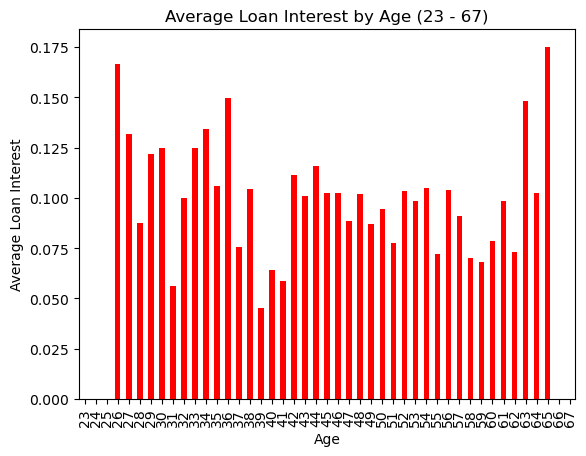

In [16]:
# Average Loan Interest by Age

loan_df.groupby(['Age'])['Personal_Loan'].mean().plot(kind='bar', color=['red'])
plt.title('Average Loan Interest by Age (23 - 67)')
plt.xlabel('Age')
plt.ylabel('Average Loan Interest');

- There is a slight increase in loan interest as the customer's age increases, although the effect is not drastic.

**5. How does a customer's interest in purchasing a loan vary with their education?**

In [17]:
#summary stats

loan_df[['Personal_Loan', 'Education']].describe()

,Personal_Loan,Education
count,5000.000000,5000.000000
mean,0.096000,1.881000
std,0.294621,0.839869
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,0.000000,3.000000
max,1.000000,3.000000


In [18]:
# Education column: value counts

loan_df['Education'].value_counts(normalize=True)

Education
1    0.4192
3    0.3002
2    0.2806
Name: proportion, dtype: float64

In [19]:
# frequency of customers, by Education level, who are or aren't interested in loans
pd.crosstab(loan_df['Education'], loan_df['Personal_Loan'])

Personal_Loan,0,1
Education,,
1,2003,93
2,1221,182
3,1296,205


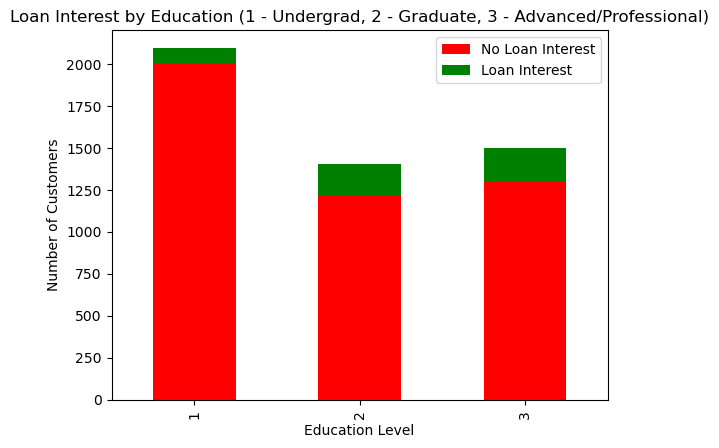

In [20]:
# frequency of customers, by Education level, who are or aren't interested in loans

pd.crosstab(loan_df['Education'], loan_df['Personal_Loan']).plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Loan Interest by Education (1 - Undergrad, 2 - Graduate, 3 - Advanced/Professional)')
plt.xlabel('Education Level')
plt.ylabel('Number of Customers')
plt.legend(['No Loan Interest', 'Loan Interest']);

In [21]:
# chi-square test

contingency_table = pd.crosstab(loan_df['Education'], loan_df['Personal_Loan'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}')
print(f'P-Value: {p}')

Chi-Square Statistic: 111.2398718738913
P-Value: 6.991473868665428e-25


In [22]:
edu_loan = loan_df.groupby(['Education'])['Personal_Loan'].mean()
edu_loan

Education
1    0.044370
2    0.129722
3    0.136576
Name: Personal_Loan, dtype: float64

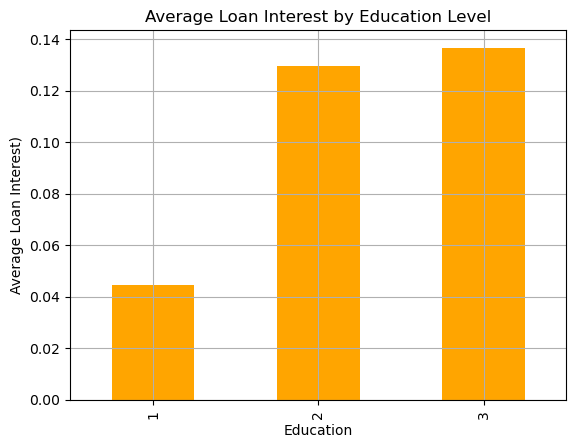

In [23]:
edu_loan.plot(kind='bar', color='orange')
plt.title('Average Loan Interest by Education Level')
plt.xlabel('Education')
plt.ylabel('Average Loan Interest)')
plt.grid(True);

- Customers with higher education levels show a slightly higher likelihood of purchasing a loan. The education level 3 has the highest loan interest rates.

## Data Preprocessing

**Outlier Treatment**

In [24]:
# create a copy of loan_df

df = loan_df.copy()
df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


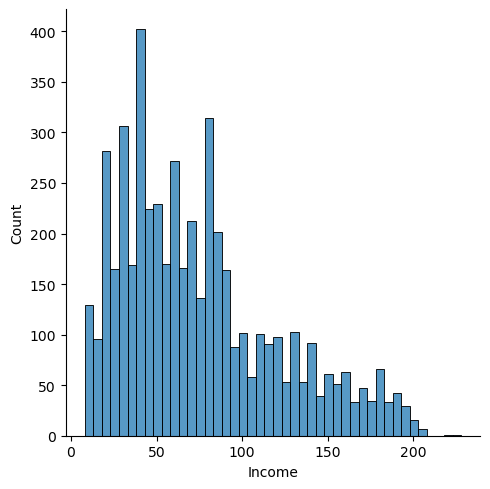

In [25]:
# distribution of income attribute
sns.displot(df, x="Income", binwidth=5);

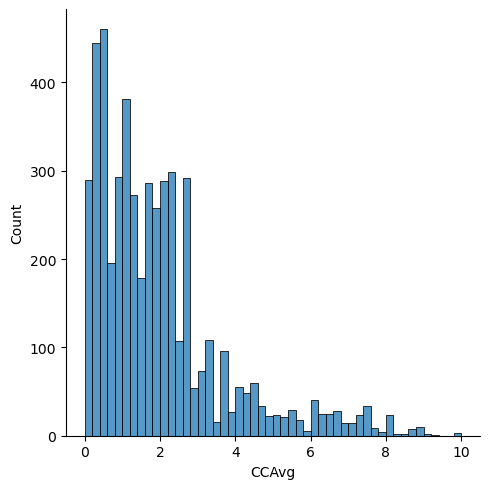

In [26]:
# distribution of income attribute
sns.displot(df, x="CCAvg", binwidth=.2);

- `Income`, `CCAvg`, and `Mortgage` columns have skewed distribution
- Log transformation is used below to help stabilize variance and reduce skewness in `Income` and `CCAvg`

In [27]:
# using log transformation to help stabilize variance and reduce skewness in Income and CCAvg

df['Income_Log'] = np.log(df['Income'] + 1)
df['CCAvg_Log'] = np.log(df['CCAvg'] + 1)

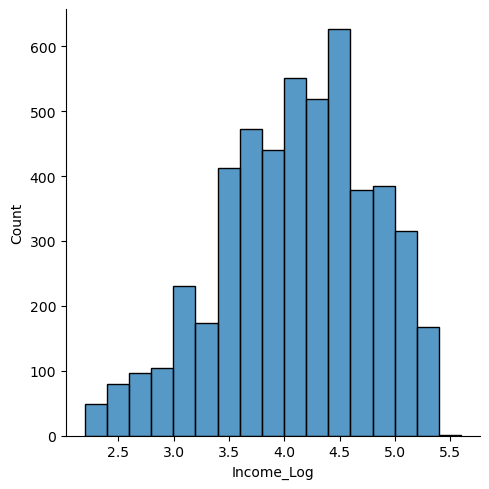

In [28]:
# distribution of Income_Log attribute
sns.displot(df, x="Income_Log", binwidth=.2);

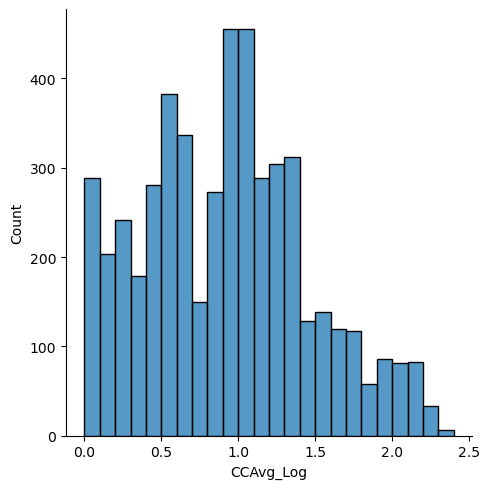

In [29]:
# distribution of CCAvg_Log attribute
sns.displot(df, x="CCAvg_Log", binwidth=.1);

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
 14  Income_Log          5000 non-null   float64
 15  CCAvg_Log           5000 non-null   float64
dtypes: flo

**Feature engineering**

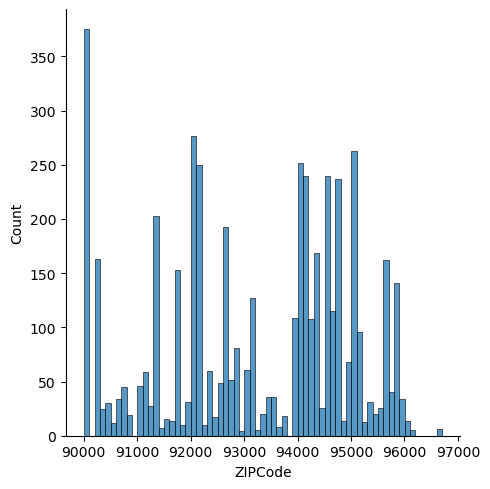

In [31]:
# distribution of ZIPCode attribute
sns.displot(loan_df, x="ZIPCode", binwidth=100);

In [32]:
# checking if ZIPCode has a significant effect on customer interest in purchasing a loan

groups = [loan_df['Personal_Loan'][loan_df['ZIPCode'] == category] for category in loan_df['ZIPCode'].unique()]
stat, p_value = kruskal(*groups)

print(f'Kruskal-Wallis Stastistic: {stat}, P-value: {p_value}')

Kruskal-Wallis Stastistic: 444.0630245487607, P-value: 0.7606014754890098


- Based on Kruskal-Wallis results, there is no statistically significant difference in the distribution of `PersonaL_Loan` across the different ZIP codes in `loan_df`

In [33]:
# checking if Age has a significant effect on customer interest in purchasing a loan

groups = [loan_df['Personal_Loan'][loan_df['Age'] == category] for category in loan_df['Age'].unique()]
stat, p_value = kruskal(*groups)

print(f'Kruskal-Wallis Stastistic: {stat}, P-value: {p_value}')

Kruskal-Wallis Stastistic: 55.17991866353909, P-value: 0.12033022024629739


**Preparing data for modeling**

In [34]:
# assign features and label
columns = df[['Age', 'Experience', 'Family', 'Education', 
              'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 
              'Income_Log', 'CCAvg_Log', 'Mortgage']]
features = columns
label = loan_df['Personal_Loan']

In [35]:
features.head()

,Age,Experience,Family,Education,Securities_Account,CD_Account,Online,CreditCard,Income_Log,CCAvg_Log,Mortgage
0,25,1,4,1,1,0,0,0,3.912023,0.955511,0
1,45,19,3,1,1,0,0,0,3.555348,0.916291,0
2,39,15,1,1,0,0,0,0,2.484907,0.693147,0
3,35,9,1,2,0,0,0,0,4.615121,1.308333,0
4,35,8,4,2,0,0,0,1,3.828641,0.693147,0


In [36]:
# train-test split

feature_train, feature_test, label_train, label_test = train_test_split(features, label, train_size = 0.8, random_state = 1)

print(f"Number of rows in Train data: {feature_train.shape[0]}")
print(f"Number of rows in test data: {feature_test.shape[0]}")

Number of rows in Train data: 4000
Number of rows in test data: 1000


In [37]:
# standardize data

scaler = StandardScaler()
feature_train = scaler.fit_transform(feature_train)
feature_test = scaler.transform(feature_test)

## Model Building

### Model Evaluation Criterion

In [38]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_sklearn(model, features, label):

    pred = model.predict(features)

    acc = accuracy_score(label, pred)  
    recall = recall_score(label, pred)  
    precision = precision_score(label, pred)  
    f1 = f1_score(label, pred)  

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [39]:
# defining a function to compute confusion_matrix
def confusion_matrix_sklearn(model, features, label):
   
    y_pred = model.predict(features)
    cm = confusion_matrix(label, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Model Building

**Decision Tree (Default)**

In [40]:
# base model

model0 = DecisionTreeClassifier(criterion="gini", random_state=1)
model0.fit(feature_train, label_train)

DecisionTreeClassifier(random_state=1)

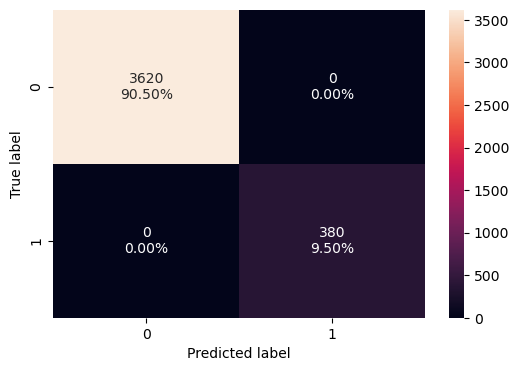

In [41]:
# confusion matrix of base model performance - train data

confusion_matrix_sklearn(model0, feature_train, label_train)

In [42]:
# base model performance on train data
DT_basemodel_perf_train = model_performance_sklearn(
    model0, feature_train, label_train
)

DT_basemodel_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


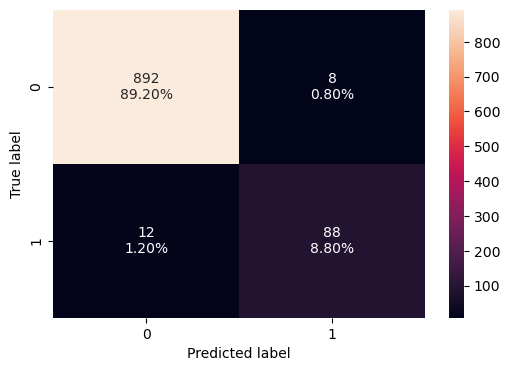

In [43]:
# confusion matrix of base model performance - test data

confusion_matrix_sklearn(model0, feature_test, label_test)

In [44]:
# base model performance on test data

DT_basemodel_perf_test = model_performance_sklearn(
    model0, feature_test, label_test
)
DT_basemodel_perf_test

,Accuracy,Recall,Precision,F1
0,0.98,0.88,0.916667,0.897959


In [45]:
# column names

feature_names = list(features.columns)
print(feature_names)

['Age', 'Experience', 'Family', 'Education', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Income_Log', 'CCAvg_Log', 'Mortgage']


In [46]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model0, feature_names=feature_names, show_weights=True))

|--- Income_Log <= 0.94
|   |--- CCAvg_Log <= 0.84
|   |   |--- Income_Log <= 0.84
|   |   |   |--- weights: [2912.00, 0.00] class: 0
|   |   |--- Income_Log >  0.84
|   |   |   |--- Family <= 0.96
|   |   |   |   |--- Education <= -0.45
|   |   |   |   |   |--- weights: [33.00, 0.00] class: 0
|   |   |   |   |--- Education >  -0.45
|   |   |   |   |   |--- Age <= -1.47
|   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |--- Age >  -1.47
|   |   |   |   |   |   |--- Experience <= -0.05
|   |   |   |   |   |   |   |--- Age <= -1.03
|   |   |   |   |   |   |   |   |--- weights: [6.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- Age >  -1.03
|   |   |   |   |   |   |   |   |--- Family <= -0.78
|   |   |   |   |   |   |   |   |   |--- weights: [2.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Family >  -0.78
|   |   |   |   |   |   |   |   |   |--- CreditCard <= 0.45
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   | 

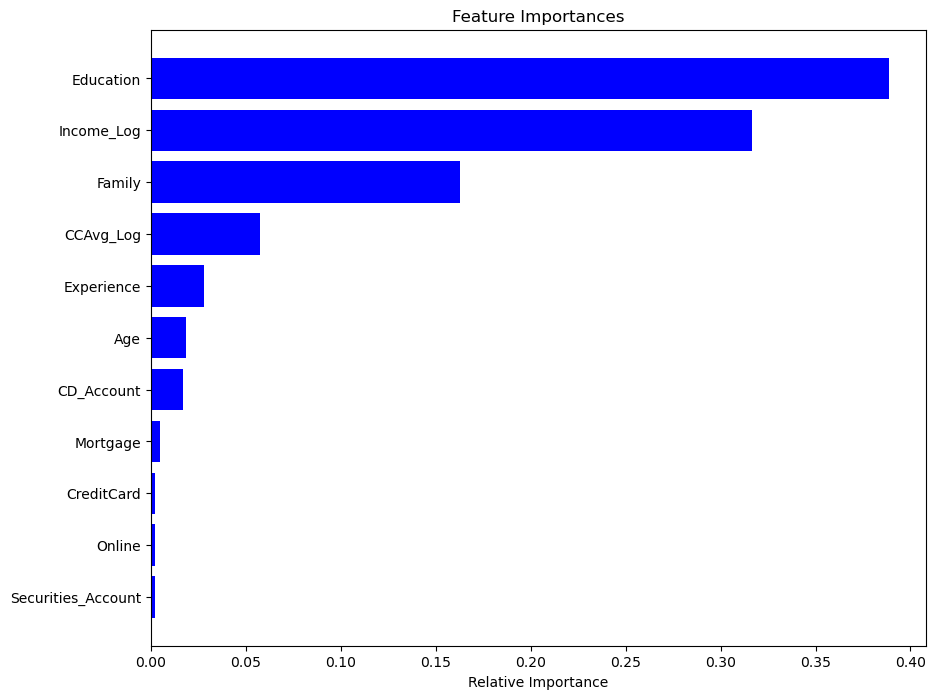

In [47]:
#plot features' importance

importances = model0.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="blue", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

<br>

## Model Performance Improvement

**Decision Tree (Pre-Pruning)**

In [48]:
# Define parameters for DT to loop over
max_depth_values = np.arange(2, 8, 2)
max_leaf_nodes_values = [40, 80, 150, 250]
min_samples_split_values = [5, 25, 50, 70]

# Initialize variables to store the best model and its performance
best_estimator = None
best_score_diff = float('inf')
best_test_score = 0.0

# Iterate over all combinations of the specified parameter values
for max_depth in max_depth_values:
    for max_leaf_nodes in max_leaf_nodes_values:
        for min_samples_split in min_samples_split_values:

            estimator = DecisionTreeClassifier(
                max_depth=max_depth,
                max_leaf_nodes=max_leaf_nodes,
                min_samples_split=min_samples_split,
                class_weight='balanced',
                random_state=1
            ).fit(feature_train, label_train)

            # Make predictions on the training and test sets
            label_train_pred = estimator.predict(feature_train)
            label_test_pred = estimator.predict(feature_test)

            # Calculate recall scores for training and test sets
            train_recall_score = recall_score(label_train, label_train_pred)
            test_recall_score = recall_score(label_test, label_test_pred)

            # Calculate the absolute difference between training and test recall scores
            score_diff = abs(train_recall_score - test_recall_score)

            # Update the best estimator and best score if the current one has a smaller score difference
            if (score_diff < best_score_diff) & (test_recall_score > best_test_score):
                best_score_diff = score_diff
                best_test_score = test_recall_score
                best_estimator = estimator

# creating an instance of the best model
model1 = best_estimator

# Print the best parameters
print("Best parameters found:")
print(f"Max depth: {best_estimator.max_depth}")
print(f"Max leaf nodes: {best_estimator.max_leaf_nodes}")
print(f"Min samples split: {best_estimator.min_samples_split}")
print(f"Best test recall score: {best_test_score}")

Best parameters found:
Max depth: 2
Max leaf nodes: 40
Min samples split: 5
Best test recall score: 1.0


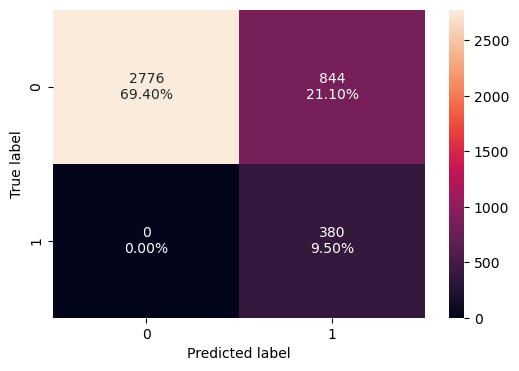

In [49]:
# fitting the best model to the training data
model1.fit(feature_train, label_train)

# confusion matrix of tuned model performance - train data
confusion_matrix_sklearn(model1, feature_train, label_train)

In [50]:
# base model performance on train data

DT_tuned_perf_train = model_performance_sklearn(
    model1, feature_train, label_train
)
DT_tuned_perf_train

,Accuracy,Recall,Precision,F1
0,0.789,1.0,0.310458,0.473815


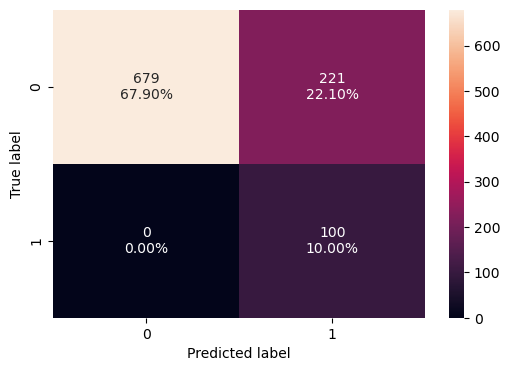

In [51]:
# confusion matrix of tuned model performance - test data

confusion_matrix_sklearn(model1, feature_test, label_test)

In [52]:
# base model performance on test data

DT_tuned_perf_test = model_performance_sklearn(
    model1, feature_test, label_test
)
DT_tuned_perf_test

,Accuracy,Recall,Precision,F1
0,0.779,1.0,0.311526,0.475059


In [53]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model1, feature_names=feature_names, show_weights=True))

|--- Income_Log <= 0.64
|   |--- CCAvg_Log <= 0.84
|   |   |--- weights: [1533.70, 0.00] class: 0
|   |--- CCAvg_Log >  0.84
|   |   |--- weights: [70.72, 84.21] class: 1
|--- Income_Log >  0.64
|   |--- Education <= -0.45
|   |   |--- weights: [319.89, 331.58] class: 1
|   |--- Education >  -0.45
|   |   |--- weights: [75.69, 1584.21] class: 1



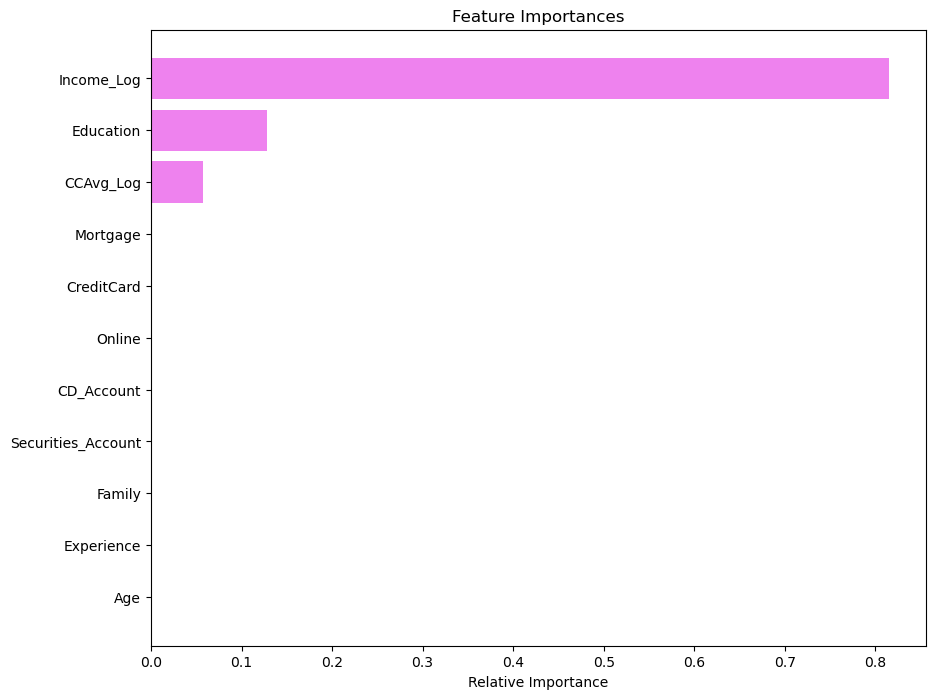

In [54]:
#plot features' importance

importances = model1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Decision Tree (Post-Pruning)**

In [55]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(feature_train, label_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [56]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000200,0.000400
2,0.000219,0.000837
3,0.000226,0.001289
4,0.000236,0.002233
5,0.000237,0.002707
6,0.000245,0.003197
7,0.000273,0.004015
8,0.000309,0.005870
9,0.000310,0.006801


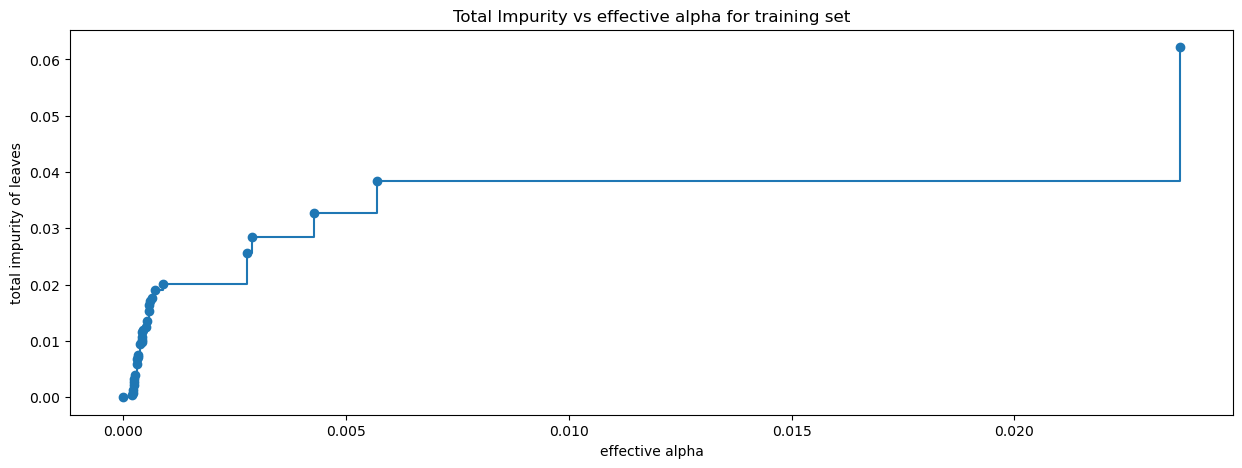

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [58]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(feature_train, label_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.05488890137246506


In [59]:
clfs

[DecisionTreeClassifier(random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00019999999999999996, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00021875, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.0002256944444444444, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00023611111111111117, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00023684210526315802, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00024489795918367357, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00027272727272727274, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.0003090909090909091, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.000310418904403867, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.0003333333333333333, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.0003333333333333333, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.00038442356721265684, random_state=1),
 DecisionTreeClassifier(ccp_alpha=0.0004166666666666667, random_state=1),
 De

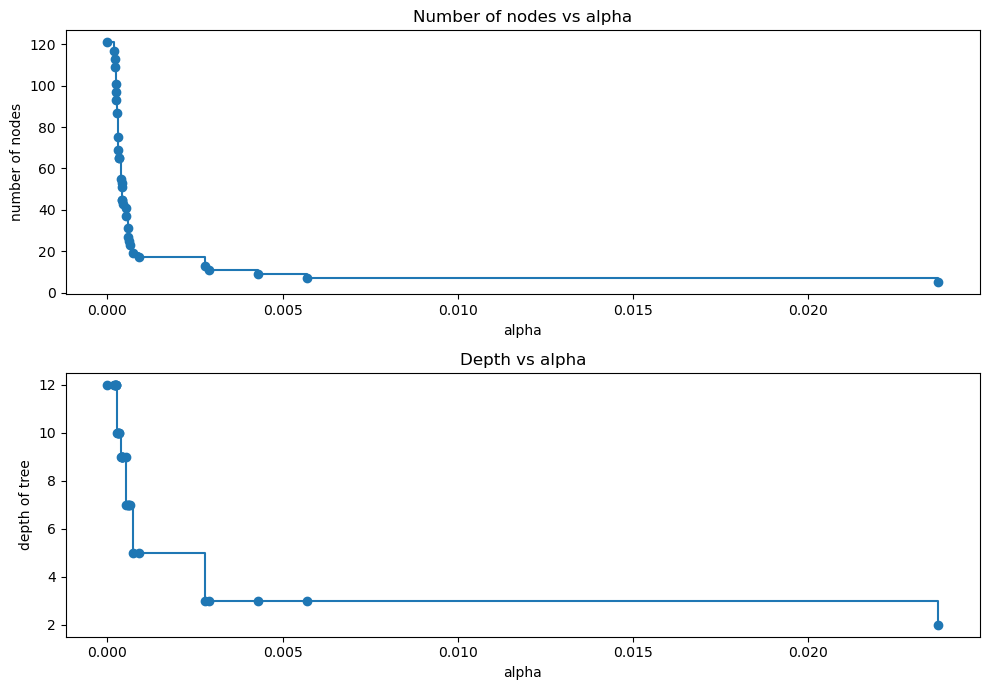

In [60]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [61]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(feature_train)
    values_train = recall_score(label_train, pred_train)
    recall_train.append(values_train)
    
recall_test = []
for clf in clfs:
    pred_test = clf.predict(feature_test)
    values_test = recall_score(label_test, pred_test)
    recall_test.append(values_test)

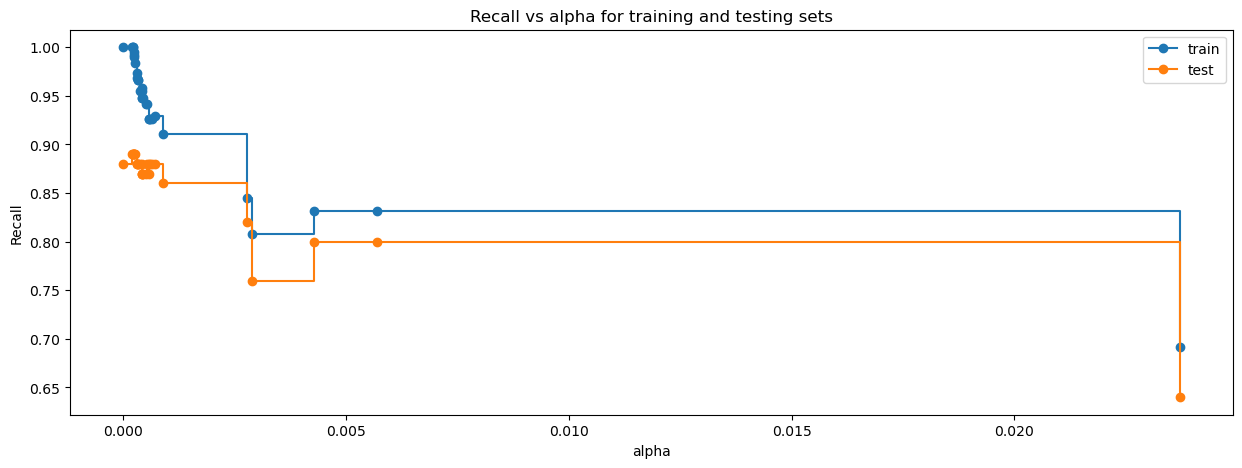

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [63]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.00019999999999999996, random_state=1)


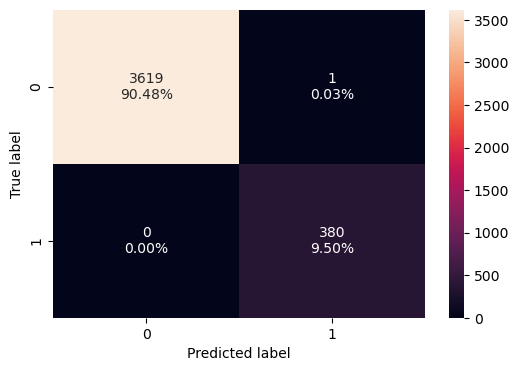

In [64]:
model2 = best_model
confusion_matrix_sklearn(model2, feature_train, label_train)

In [65]:
DT_postpruned_perf_train = model_performance_sklearn(
    model2, feature_train, label_train
)
DT_postpruned_perf_train

,Accuracy,Recall,Precision,F1
0,0.99975,1.0,0.997375,0.998686


In [66]:
DT_postpruned_perf_test = model_performance_sklearn(
    model2, feature_test, label_test
)
DT_postpruned_perf_test

,Accuracy,Recall,Precision,F1
0,0.981,0.89,0.917526,0.903553


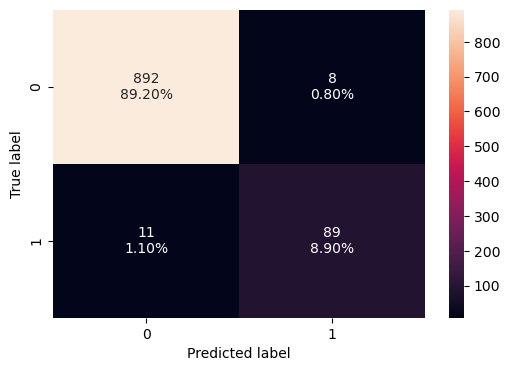

In [67]:
confusion_matrix_sklearn(model2, feature_test, label_test)

In [68]:
# Text report showing the rules of a decision tree -

print(tree.export_text(model2, feature_names=feature_names, show_weights=True))

|--- Income_Log <= 0.94
|   |--- CCAvg_Log <= 0.84
|   |   |--- Income_Log <= 0.84
|   |   |   |--- weights: [2912.00, 0.00] class: 0
|   |   |--- Income_Log >  0.84
|   |   |   |--- Family <= 0.96
|   |   |   |   |--- Education <= -0.45
|   |   |   |   |   |--- weights: [33.00, 0.00] class: 0
|   |   |   |   |--- Education >  -0.45
|   |   |   |   |   |--- Age <= -1.47
|   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |--- Age >  -1.47
|   |   |   |   |   |   |--- Experience <= -0.05
|   |   |   |   |   |   |   |--- Age <= -1.03
|   |   |   |   |   |   |   |   |--- weights: [6.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- Age >  -1.03
|   |   |   |   |   |   |   |   |--- Family <= -0.78
|   |   |   |   |   |   |   |   |   |--- weights: [2.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Family >  -0.78
|   |   |   |   |   |   |   |   |   |--- CreditCard <= 0.45
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   | 

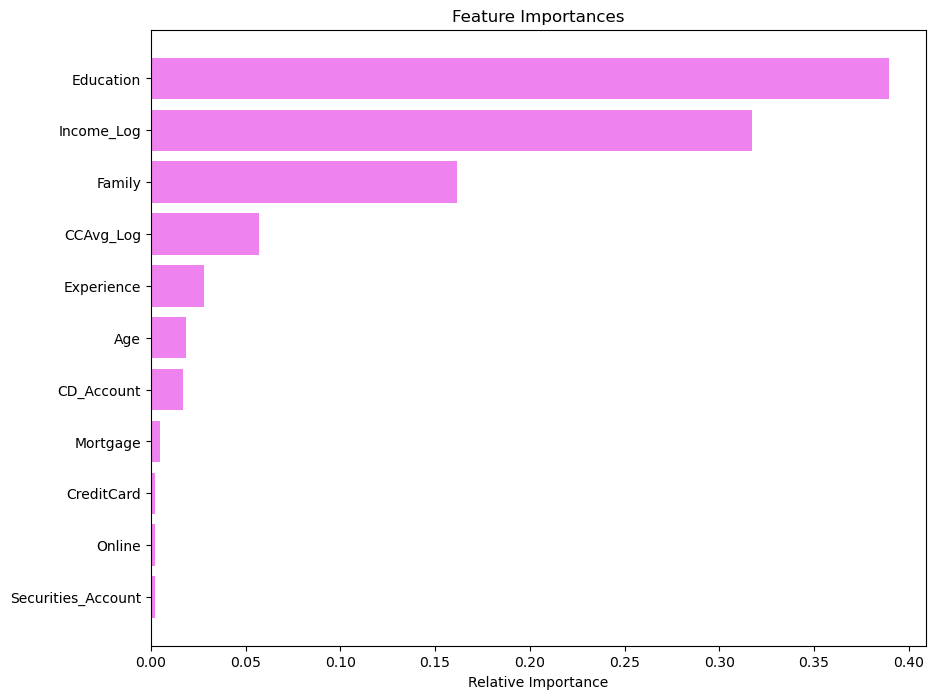

In [69]:
#plot features' importance

importances = model2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Model Performance Comparison and Final Model Selection

In [70]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        DT_basemodel_perf_train.T,
        DT_tuned_perf_train.T,
        DT_postpruned_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree (Base Model)",
    "Decision Tree (Pre-Pruning/Tuned)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree (Base Model),Decision Tree (Pre-Pruning/Tuned),Decision Tree (Post-Pruning)
Accuracy,1.0,0.789000,0.999750
Recall,1.0,1.000000,1.000000
Precision,1.0,0.310458,0.997375
F1,1.0,0.473815,0.998686


In [71]:
# test set performance comparison

models_test_comp_df = pd.concat(
    [
        DT_basemodel_perf_test.T,
        DT_tuned_perf_test.T,
        DT_postpruned_perf_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree (Base Model)",
    "Decision Tree (Pre-Pruning/Tuned)",
    "Decision Tree (Post-Pruning)",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Decision Tree (Base Model),Decision Tree (Pre-Pruning/Tuned),Decision Tree (Post-Pruning)
Accuracy,0.980000,0.779000,0.981000
Recall,0.880000,1.000000,0.890000
Precision,0.916667,0.311526,0.917526
F1,0.897959,0.475059,0.903553


- The Decision tree with post-pruning has the highest accuracy, recall, precision and F1 scores on the test set.

## Actionable Insights and Business Recommendations


1. The Decision Tree with post-pruning showed the highest accuracy, recall, precision, and F1 score on the test set. Thus, the final recommendation is to deploy the **post-pruned decision tree** model for predicting customers who are more likely to purchase loans.

2. From the analysis of features like age and education, customers with higher education levels tend to show a slightly higher interest in purchasing loans. I found that higher education levels correlate with a higher likelihood of purchasing loans. I therefore recommend that **targeting educated customers** with loan offers might result in better conversion rates.

3. Given that certain customer demographics (like those with higher education) are more likely to take loans, it may be valuable for AllLife Bank to run more **targeted marketing campaigns** for these groups.